## Draft from AUV and draft from LiDAR plus some models...
Adam Steer, adam.d.steer@gmail.com

Here I'm using AUV draft as 'truth' to look at some parameters for modelling sea ice thickness. My aims are:

- get descriptive stats from a patch of LiDAR-derived draft pretty close (within 1-sigma) of AUV draft

To do this I'm using the previously levelled and filtered LiDAR data from SIPEX2 IS6, which is also resgistered int the same coordinate system as the UAV draft.

So the first approach is to use a snow model from all possible drill holes in East Anarctica and mess with snow and ice density (probably ice density, because it is least well described) until things line up.

The second approach is to try on a few snow models.

Here we go...

In [1]:
import numpy as np

In [2]:
## read in some pre-processed liDAR. This 2 million point bit already has ZI computed, but we ignore that for now
lidar = np.genfromtxt('/media/adam/data/is6_f11/python_zi/is6_f11_pass1_aa_nr2_522816_523019_zi_data.xyz')

In [4]:
# get a subset inside the AUV grid
subset = lidar[(lidar[:,1] >= -150) & (lidar[:,1] <= 130) & (lidar[:,2] >= -30) & (lidar[:,2] <= 275) ]

In [ ]:
lidar_t = np.where()

In [4]:
# this function is the snow depth model. Parameters come from Steer et al (2016):
#Estimating snow depth from altimery for East Antarctic pack ice

def compute_zs(tf, s_i, tf_uncert):
    """
    Take in the total freeboard (tf, float array), slope and intercept for an empirical model
    of snow depth from elevation (s_i, tuple) and the total freeboard uncertainty
    (tf_uncert, float array)

    Return a snow depth, with an associated uncertainty.
    zs, uncert = compute_zs(tf, ([slope, intercept]), tf_uncert)
    """
    
    zs = (s_i[0] * tf) + s_i[1]

    zs_uncert = 0.701 * tf_uncert

    return zs, zs_uncert


In [5]:
# next define the model for estimating ice thickness from total freeboard, snow depth
# and some density parameters:

def compute_zi(tf, zs, d_ice, d_water, d_snow, sd_tf, sd_zs, sd_dsnow, \
               sd_dice, sd_dwater):
    """"
    sea ice thickness from elevation, and propagation of uncertainties
    after Kwok, 2010; kwok and cunningham, 2008
    equations:
    4: sea ice thickness from elevation
    6: taylor series expansion of variance/covariance propagation using
    partial derivatives
    8, 9 and 10: partial derivatives used in the taylor series
    """
    zi = (d_water / (d_water-d_ice)) * tf - ((d_water-d_snow) / \
         (d_water - d_ice)) * zs

    zi_uncert = sd_tf**2 * (d_water / (d_water - d_ice))**2 + \
           sd_zs**2 * ((d_snow - d_water) / (d_water - d_ice))**2 + \
           sd_dsnow**2 * (zs / (d_water - d_ice))**2 + \
           sd_dice**2 * (tf /  (d_water - d_ice))**2 + \
           sd_dwater**2 * (((-d_ice * tf) + ((d_ice-d_snow) * zs)) / \
           (d_water - d_ice)**2)**2

    return zi, zi_uncert


In [6]:
#these parameters drive the sea ice thickness estimation model
d_snow = 305.67 #mean of all EA obs
sd_dsnow = 10
d_ice = 887 #messing around here....
sd_dice = 10
d_water = 1028
sd_dwater = 1

### Looks like 887 is the magic density number!
(for this snow model)

In [7]:
tf = subset[:,3]
sd_tf = subset[:,4]

In [8]:
#compute snow depth based on an empirical model
s_i = ([0.701, -0.0012]) #model from all EA drill holes
zs, zs_uncert = compute_zs(tf, s_i, sd_tf)

#...and finally ice thickness!
zi, zi_uncert = compute_zi(tf, zs, d_ice, d_water, d_snow, sd_tf, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)

In [9]:
draft = abs(tf - (zs +zi))

In [10]:
print('mean draft: {} min draft: {} max draft: {} std draft: {}'.
      format(np.mean(draft), np.min(draft),np.max(draft), np.std(draft)))

mean draft: 3.2236051346901817 min draft: 0.4361463301843973 max draft: 14.565729797205673 std draft: 1.1697983146130397


In [11]:
print('mean zi: {} mean zs: {}'.
      format(np.mean(zi), np.min(zs)))

mean zi: 3.5078059210699504 mean zs: 0.08768679999999998


### in situ mean snow depth was 0.27 m, ice thickness 1.731 m, from the transect line.

In [12]:
auv = np.genfromtxt('/media/adam/data/is6_f11/lidar_auv_analysis/auv_subset.txt')

In [13]:
auv_draft = auv[:,2]

In [14]:
print('mean draft: {} min draft: {} max draft: {} std draft: {}'.
      format(np.mean(auv_draft), np.min(auv_draft), np.max(auv_draft), np.std(auv_draft)))

mean draft: 3.2371440703565115 min draft: -0.1337 max draft: 16.203 std draft: 1.9381890100880586


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,16
#plt.plot(draft)

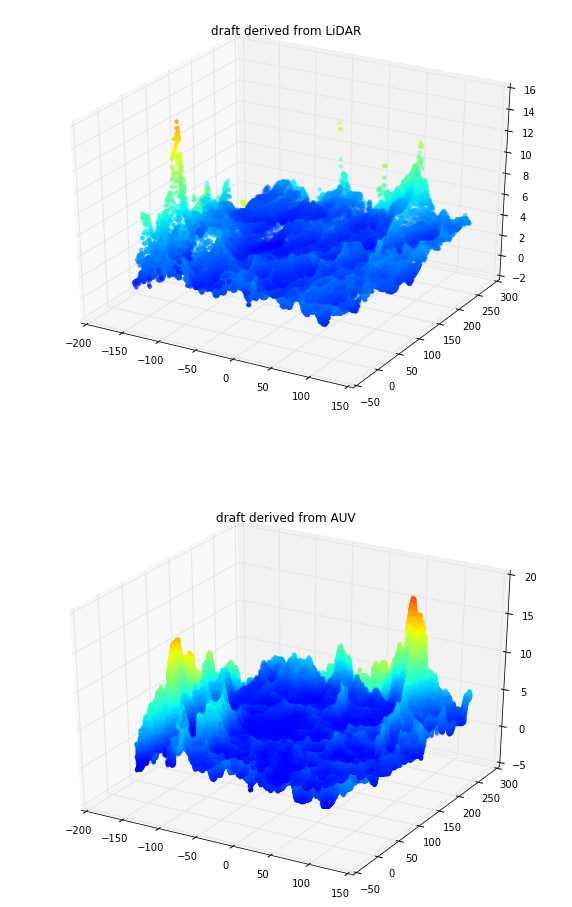

In [16]:
fig = plt.figure()
ax = fig.add_subplot(211, projection='3d')
ax.scatter(subset[:,1], subset[:,2], draft, c=np.ndarray.tolist(draft), lw=0, vmin=-2, vmax = 20)
plt.title('draft derived from LiDAR')

ax = fig.add_subplot(212, projection='3d')
ax.scatter(auv[:,0], auv[:,1], auv_draft, c=np.ndarray.tolist(auv_draft), lw=0, vmin=-2, vmax = 20)
plt.title('draft derived from AUV')


## Summary of part 1:

Pretty much as expected, the broad stats agree (min, max, mean). Lower SD in the LiDAR patch means that the underside of the ice is rougher than the top side predicts.

887 (kg/m**3) is the most magical of the ice density numbers tried.

Interestingly, the deepest keels from LIDAR are not in the same spot as the deepest keels from the AUV.

However - ridges/keels seem fairly correlated - it makes sense on a blurry global grid scale.

On a floe-scale, it mostly makes sense. There are deep bits pretty much where they should be. And shallow bits pretty much in the right place. Not exactly right, but also not insanely crap.


## Part 2: As above, with the snow model from SIPEX-2 observations only

I would hesitate to say that the SIPEX2 snow model is anything like truth, there's a really weak relationship between freeboard and snow depth on that trip. Any wonder? Anyway, it needs to be done...

In [24]:
#compute snow depth based on an empirical model
s_i = ([0.64, 0.076]) #model from all EA drill holes
zs, zs_uncert = compute_zs(tf, s_i, sd_tf)

#need to creep up the ice density. Will check back on Jenny's paper
# But I'm pretty sure this is maxing out the density range observed - so
# it is effectively not real. Or the snow model is awful.
d_ice  =891

#...and finally ice thickness!
zi, zi_uncert = compute_zi(tf, zs, d_ice, d_water, d_snow, sd_tf, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)

In [25]:
draft = abs(tf - (zs +zi))
print('mean draft: {} min draft: {} max draft: {} std draft: {}'.
      format(np.mean(draft), np.min(draft),np.max(draft), np.std(draft)))

mean draft: 3.242863011930411 min draft: 0.15323372145985412 max draft: 15.814514480583941 std draft: 1.2966086282349


In [26]:
print('mean zi: {} mean zs: {}'.
      format(np.mean(zi), np.min(zs)))

mean zi: 3.507599744695351 mean zs: 0.15715200000000001


#### Slightly better snow depth, though. Maybe not crap after all! ted's probe data is going to pWn this though...

no plot. Ah.. Ok. Plot.

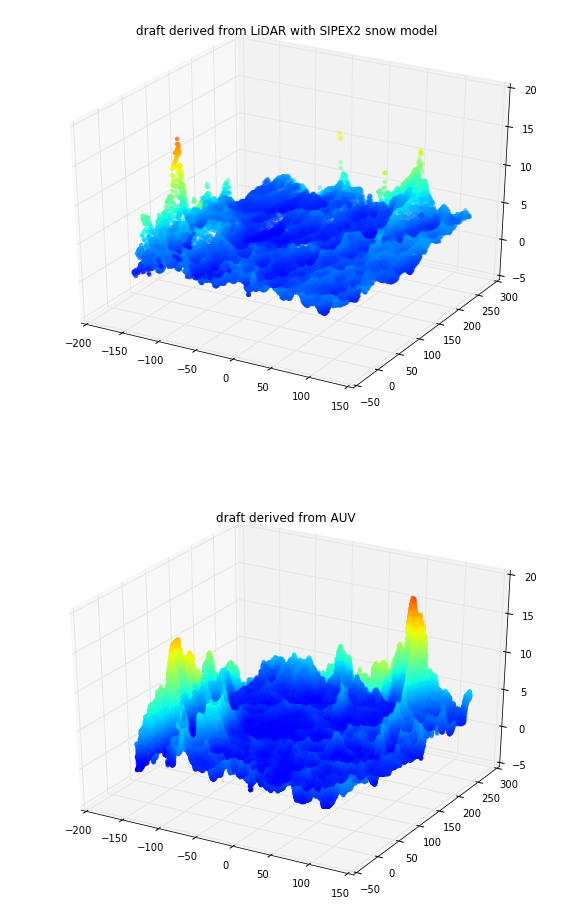

In [27]:
fig = plt.figure()
ax = fig.add_subplot(211, projection='3d')
ax.scatter(subset[:,1], subset[:,2], draft, c=np.ndarray.tolist(draft), lw=0, vmin=-2, vmax = 20)
plt.title('draft derived from LiDAR with SIPEX2 snow model')

ax = fig.add_subplot(212, projection='3d')
ax.scatter(auv[:,0], auv[:,1], auv_draft, c=np.ndarray.tolist(auv_draft), lw=0, vmin=-2, vmax = 20)
plt.title('draft derived from AUV')

In [36]:
##save the draft to a file!
draft_out = np.column_stack((subset[:,1], subset[:,2], draft))
np.savetxt('/media/adam/data/is6_f11/lidar_auv_analysis/lidar_draft_s2snow_891.txt', draft_out)

## Done!

...now what else? Apply to 60nm of LiDAR! yeah!

In [32]:
#need to creep up the ice density. Will check back on Jenny's paper
# But I'm pretty sure this is maxing out the density range observed - so
# it is effectively not real. Or the snow model is awful.
d_ice  =870

#...and finally ice thickness!
zi, zi_uncert = compute_zi(tf, zs, d_ice, d_water, d_snow, sd_tf, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)

In [31]:
draft = abs(tf - (zs +zi))
print('mean draft: {} min draft: {} max draft: {} std draft: {}'.
      format(np.mean(draft), np.min(draft),np.max(draft), np.std(draft)))


mean draft: 3.217445622476098 min draft: 0.1523432742028986 max draft: 15.689297361159419 std draft: 1.286315534181383
